In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import wcs
from astropy.io import fits
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column,vstack
from astropy.io.votable import writeto as writetoVO
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from scipy import ndimage, misc


# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg,calc_img_bkg_rms
import snrfit

# For downlaoding images.
import gleam_client

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
def background_estimator(img_arr,constants,mask):
    """
    Estimate Background.
    
    Parameters:
    ----------
    img_arr : numpy array of image
    constants :[boxsize,filtersize,sigma]
    mask : mask for image
    Returns:
    ----------
    percent : float
        percentage of source removed
    """
    boxsize = (constants[0],constants[0])
    filtersize = (constants[1],constants[1])
    sigma = constants[2]
    sigma_clip = SigmaClip(sigma=sigma)

    bkg_estimator = MedianBackground(sigma_clip)

    mask = ~mask
    try:
        bkg = Background2D(img_arr, boxsize,mask=mask, filter_size=filtersize,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, exclude_percentile=10)
        img_bkg = bkg.background
    except ValueError:
        #will run this for uniform background
        img_bkg = np.zeros((np.shape(img_arr)))

    rms = np.std(img_arr[~mask])

    return img_bkg, rms

RA : 225.7083, DEC : -41.9333
Major = 30.0 [arcmin], Minor = 30.0 [arcmin]
Angular size = 1.0 [degrees]


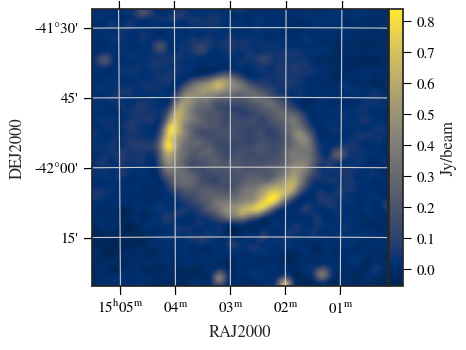

Image shape (129,129)
dx = 7.697e-03 [deg]
Image pixel center = (64.667, 64.667)
Determined the RA and DEC for the entire pixel grid.
Calculated the angular distance from each pixel to the image centre.
30.0
Max pixel = 0.1019
Max pixel = 0.0723
Max pixel = 0.0695
Max pixel = 0.0691
Max pixel = 0.0691
rms = 2.146e-02 [Jy/beam]
img_bkg = 1.550e-02 [Jy/beam]


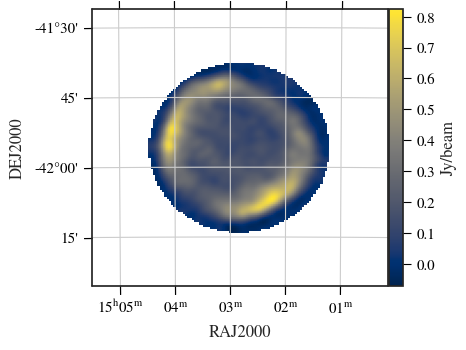

In [2]:
# Parent directory.
parent_path = '../'

# Catalogue filename.
cat_filename = 'Green-167MHz-filtered-dec+30.fits'

# Opening fits table.
cat = fits.open(parent_path + 'data/' + cat_filename)

# Creating table object.
t_SNR = Table(cat[1].data)

# SNR ID's
SNR_IDs = np.array(t_SNR['recno']).astype('int')

# Getting the RA and Dec. # These may be different for different catalogues.
RA_vec = np.array(t_SNR['_RAJ2000'])
DEC_vec = np.array(t_SNR['_DEJ2000'])
SI_vec = np.array(t_SNR['Sp-Index']) # Spectral index vector

t_SN1006 = t_SNR[t_SNR['SNR'] == 'G327.6+14.6']

RA_SN1006 = float(RA_vec[t_SNR['SNR'] == 'G327.6+14.6'])
DEC_SN1006 = float(DEC_vec[t_SNR['SNR'] == 'G327.6+14.6'])

## Looping through each SNR. This may take sometime. 
Major = float(t_SNR['MajDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]
Minor = float(t_SNR['MinDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]

# Calculating the max angular size of the ith SNR image.
ang_size = 2*Major/60 # [Degrees].

print('RA : %s, DEC : %s' % (RA_SN1006,DEC_SN1006))
print('Major = %s [arcmin], Minor = %s [arcmin]' % (Major,Minor))
print('Angular size = %s [degrees]' % ang_size)

#%%capture

# Get SNR image from GLEAM using gleam_client.
freq_range = '170-231'

filename = 'RA%5.2f_DEC%5.2f_%sMHz.fits' % (RA_SN1006,DEC_SN1006,freq_range)

# For now download to the current working directory, but you can change this to whatever you like. Typically I like to have this separate from the main directory. 
download_dir = '../data/'

if os.path.isfile(download_dir + filename) == False:
    # Tests to see if the file exists or not.
    gleam_client.vo_get(RA_SN1006, DEC_SN1006, ang_size, freq=[freq_range], 
                proj_opt='SIN', download_dir=download_dir,file_name_func=filename)

else:
    pass

warnings.filterwarnings("ignore")
with fits.open(download_dir+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]

w = WCS(header).celestial

snrfit.astro_plot_2D(img_arr, w, figsize=(7.5,6),scale=0.6)

X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

# The RA and DEC arrays, can use to determine angular mask.
RA_arr, DEC_arr = w.wcs_pix2world(xx_pix + 1, yy_pix + 1, 1)
print('Determined the RA and DEC for the entire pixel grid.')

# Calculating the angular distance from the image centre to each pixel.
theta_dist = np.degrees(snrfit.great_circle_dist(np.radians(DEC_SN1006),
                    np.radians(DEC_arr),np.radians(RA_SN1006),np.radians(RA_arr)))
print('Calculated the angular distance from each pixel to the image centre.')

print(Major)

# Temporary index array. Used for masking the image. Size padded.
theta_ind_arr_ge = theta_dist >= 0.5*Major/60 + 7.5*dx

img_bkg,rms = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge)

print('rms = %5.3e [Jy/beam]' % rms)
print('img_bkg = %5.3e [Jy/beam]' % img_bkg)


img_nu = np.ones(img_arr.shape)*img_arr - img_bkg
img_nu[theta_ind_arr_ge] = np.nan

snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)


Max pixel = 0.1019
Max pixel = 0.0723
Max pixel = 0.0695
Max pixel = 0.0691
Max pixel = 0.0691


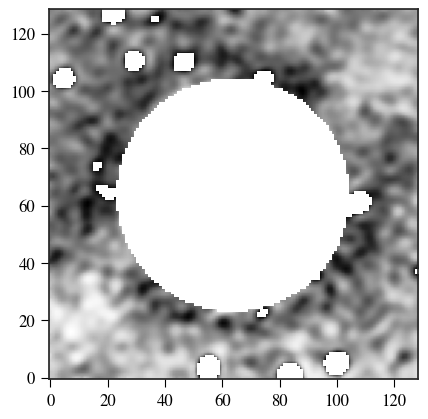

In [3]:
#thresh_mask
img_bkg,rms,clipped_mask = snrfit.calc_img_bkg_rms(img_arr,
                        mask_arr=theta_ind_arr_ge,mask_cond=True,plot_cond=True)

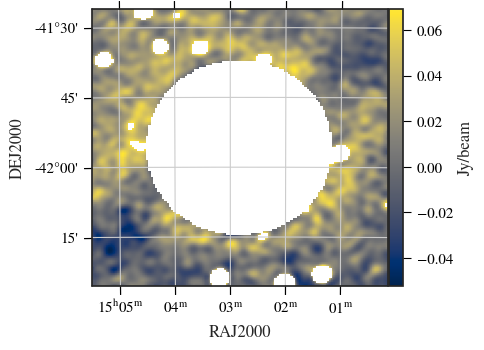

In [4]:
img_clipped = np.ones(img_arr.shape)*img_arr
img_clipped[clipped_mask] = np.nan

snrfit.astro_plot_2D(img_clipped, w, figsize=(7.5,6),scale=0.6)

In [5]:
bkg = Background2D(img_clipped, 5, filter_size=(3, 3))

(129, 129)


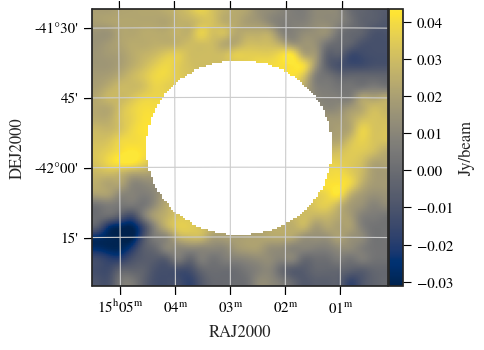

In [6]:
bkg_img = bkg.background

bkg_img[theta_ind_arr_ge == False] = np.nan

print(bkg_img.shape)
snrfit.astro_plot_2D(bkg_img, w, figsize=(7.5,6),scale=0.6)

### Interpolating with griddata

Grid data is used for non-rectlinear grids. We have to use this because of the NaN values.

In [7]:
from scipy.interpolate import griddata

points = (yy_pix[theta_ind_arr_ge],xx_pix[theta_ind_arr_ge])

interp_points = (yy_pix[theta_ind_arr_ge==False],xx_pix[theta_ind_arr_ge==False])

#method='nearest'
#method='linear'
method='cubic'

bkg_img_interp = griddata(points,bkg_img[theta_ind_arr_ge],interp_points,method=method)

In [8]:
bkg_img_nu = np.ones(bkg_img.shape)*bkg_img

bkg_img_nu[theta_ind_arr_ge==False] = bkg_img_interp

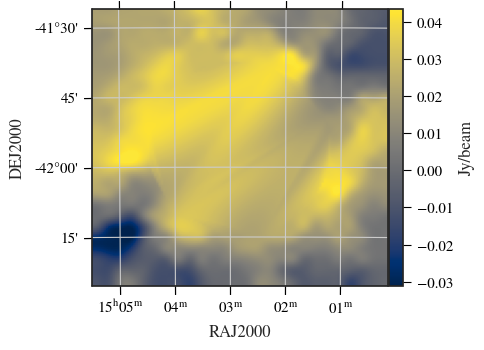

In [9]:
snrfit.astro_plot_2D(bkg_img_nu, w, figsize=(7.5,6),scale=0.6)

## Kriging

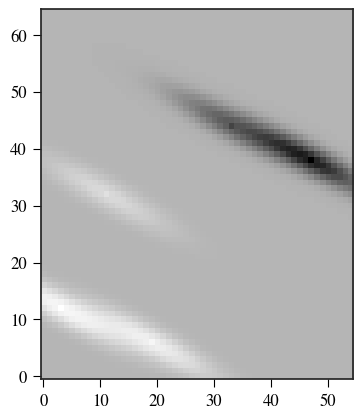

In [10]:
from pykrige.ok import OrdinaryKriging

import gstools as gs

# conditioning data
cond_x = [0.3, 1.9, 1.1, 3.3, 4.7]
cond_y = [1.2, 0.6, 3.2, 4.4, 3.8]
cond_val = [0.47, 0.56, 0.74, 1.47, 1.74]

# grid definition for output field
gridx = np.arange(0.0, 5.5, 0.1)
gridy = np.arange(0.0, 6.5, 0.1)

model = gs.Gaussian(
    dim=2, len_scale=1, anis=0.2, angles=-0.5, var=0.5, nugget=0.1
)

OK1 = OrdinaryKriging(cond_x, cond_y, cond_val, variogram_model=model)
z1, ss1 = OK1.execute("grid", gridx, gridy)
plt.imshow(z1, origin="lower")
plt.show()

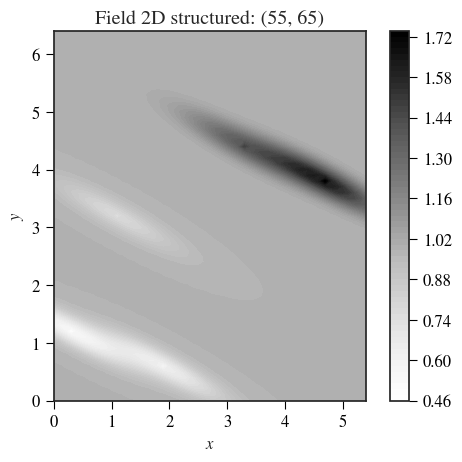

In [11]:
OK2 = gs.krige.Ordinary(model, [cond_x, cond_y], cond_val, exact=True)
OK2.structured([gridx, gridy])
ax = OK2.plot()
ax.set_aspect("equal")

In [12]:


#model = gs.Gaussian(
#    dim=2, len_scale=1, anis=0.2, angles=-0.5, var=rms**2, nugget=0.1
#)

#SNR_krig = gs.krige.Simple(model, mean = img_bkg,
#                        cond_pos=[yy_pix[theta_ind_arr_ge],xx_pix[theta_ind_arr_ge]], 
#                        cond_val=bkg_img[theta_ind_arr_ge], exact=True)

#SNR_krig = gs.krige.Ordinary(model, 
#                        [yy_pix[theta_ind_arr_ge],xx_pix[theta_ind_arr_ge]], 
#                        bkg_img[theta_ind_arr_ge], exact=True)1

In [13]:
print(x_pix[-1])

128


In [14]:


#bins = np.arange(40)
bins = np.arange(40)

bin_center, gamma = gs.vario_estimate((yy_pix[theta_ind_arr_ge],xx_pix[theta_ind_arr_ge]), 
                img_arr[theta_ind_arr_ge], bins)

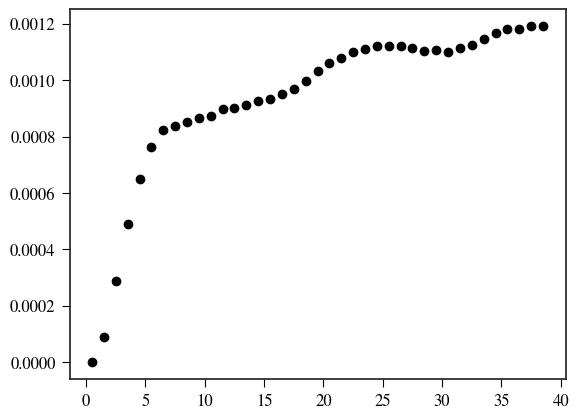

In [15]:
#print(bin_center)
#print(gamma)

# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

In [16]:
from gstools import Exponential

#model = gs.Gaussian(dim=2)
model = gs.Exponential(dim=2)
para, pcov, r2 = model.fit_variogram(bin_center, gamma, return_r2=True)


In [17]:
print(para)
print(r2)
print(pcov)

{'var': 0.0011241279042864928, 'len_scale': 6.800921001734705, 'nugget': 9.216575923363752e-06}
0.9552115821119181
[[ 2.30601674e-09 -1.36478030e-05 -2.29072536e-09]
 [-1.36478030e-05  3.32284941e-01  2.06556518e-05]
 [-2.29072536e-09  2.06556518e-05  2.57486950e-09]]


/home/jaiden/.local/lib/python3.8/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


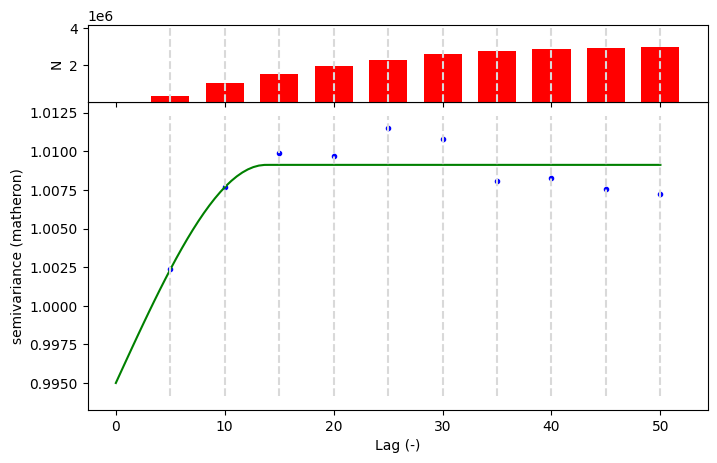

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram, OrdinaryKriging, plotting

#plotting.backend('plotly')

# Create a 2D image with some missing data
img = np.random.normal(0,1,(100, 100))
#img[3:5, 3:5] = np.nan
img[40:60, 40:60] = np.nan

# Define the spatial coordinates of the image
x, y = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))

data_points = img[np.isnan(img) == False]
x_points = x[np.isnan(img) == False]
y_points = y[np.isnan(img) == False]



V = Variogram(list(zip(x_points, y_points)), 
              data_points,
              normalize = False,
              model = "spherical",
              use_nugget = True, 
              maxlag=50)

fig = V.plot()

400


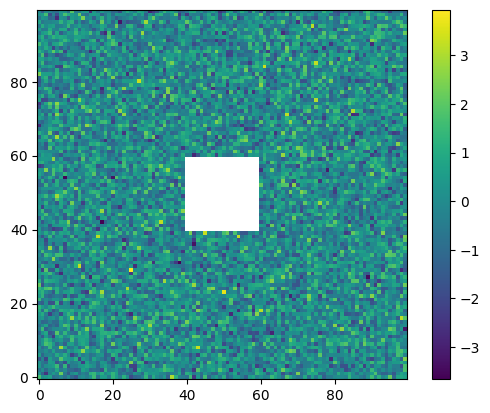

In [6]:
print(len(img[np.isnan(img)]))

plt.imshow(img,origin='lower')
plt.colorbar()

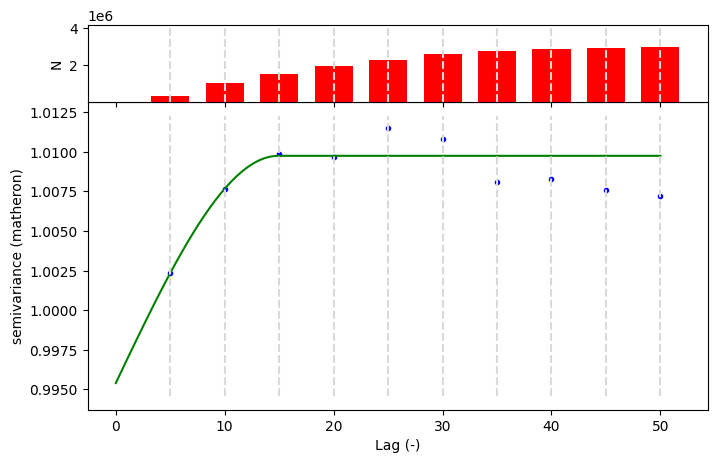

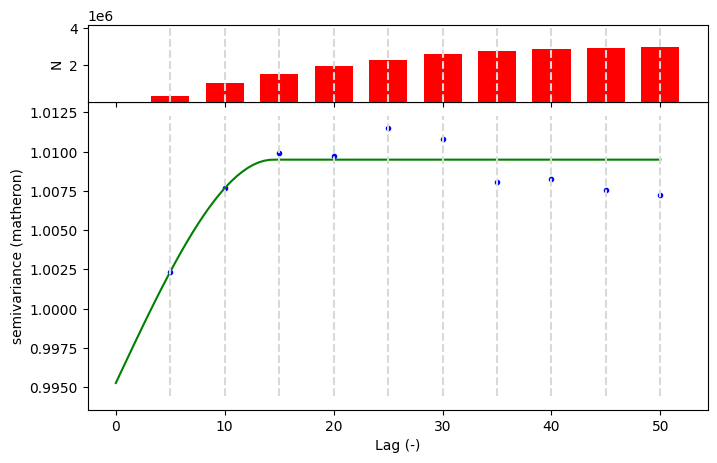

In [7]:
V.fit_sigma = 'linear'
fig1 = V.plot(show=False)
#fig1.update_layout(title='Linear Weights', width = 1000)

V.fit_sigma = 'sqrt'
fig2 = V.plot(show=False)
#fig2.update_layout(title='Sqrt-decrease Weights', width = 1000)

#fig1.show()
#fig2.show()

In [13]:
ok =  OrdinaryKriging(V, min_points=2, max_points=30, mode='exact')

# We calculate the hydraulic head on our regular grid,
# and we make the result in a good shape
hh_hat = ok.transform(x.flatten(), y.flatten()).reshape(x.shape)

# We calculate the kriging error on our grid:
s2 = ok.sigma.reshape(x.shape)

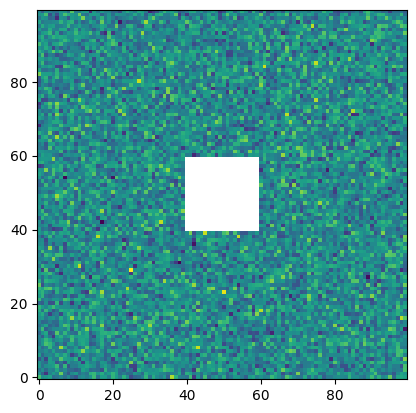

In [14]:
plt.imshow(img,origin='lower')


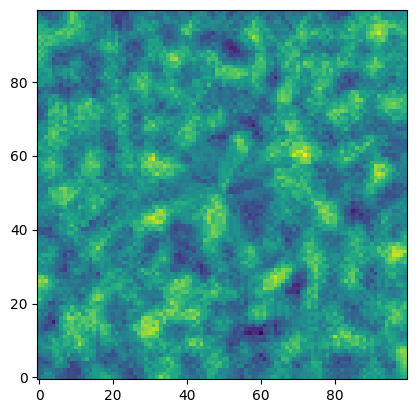

In [15]:
plt.imshow(hh_hat,origin='lower')